In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, sys, time, h5py, torch, pickle
from itertools import islice

sys.path.append('/home/mila/d/duchema/Documents/Python/equihash/')
from equihash.databases import ProceduralLabelsDB
from equihash.loaders import NoisyOpenImagesMosaic
from equihash.networks import Uint8ResNet
from equihash.utils.fingerprints import Fingerprints
from equihash.search import InvertedIndex, PrioritizedMultiProbing

def imshow(ax, x, title='', **kwargs):
    ax.imshow(x.permute(1,2,0).cpu().numpy())
    ax.set_axis_off()
    if title: ax.set_title(title, **kwargs)

In [2]:
seed = 0xace
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_grad_enabled(False)

device = 'cuda'
database_labels_path = '../data/datasets/labels/OpenImagesMosaic/1BDB.hdf5'
ground_truth_path = '../data/datasets/labels/OpenImagesMosaic/1BDB_ground_truth.pkl'
datasets_path = '../data/datasets/OpenImages/'
perlin_noise_path = '../data/datasets/PerlinNoise/perlin180x270.hdf5'

In [3]:
loader = NoisyOpenImagesMosaic(
    open_images_path=datasets_path,
    perlin_noise_path=perlin_noise_path,
    size=64, HWC=False, which='test', device=device, seed=seed
)

with h5py.File(database_labels_path, 'r') as f:
    database = ProceduralLabelsDB(f['database'][:], loader, seed=seed, use_torch=True)

with h5py.File(database_labels_path, 'r') as f:
    queries = ProceduralLabelsDB(f['positive_queries'][:], loader, seed=seed, use_torch=True)

with open(ground_truth_path, 'rb') as f:
    ground_truth = pickle.load(f)

In [4]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def timeformat(s):
    if int(s)>0: return f'{s:.2f} s'
    s *= 1000
    if int(s)>0: return f'{s:.2f} ms'
    s *= 1000
    if int(s)>0: return f'{s:.2f} µs'
    return f'{s/1000:.2f} ns'

def idformat(i):
    return '-'.join([str(i).zfill(9)[j*3:(j+1)*3] for j in range(3)])

def search(query_id, encoder, search_function, print_timing=False, row_limit=5):
    query = queries[query_id]
    torch.cuda.synchronize()
    
    t0 = time.time()
    with torch.no_grad():
        logits = encoder(query[None])[0]
        torch.cuda.synchronize()
    encoding_time = time.time() - t0
    
    t0 = time.time()
    index = search_function(logits)
    search_time = time.time() - t0
    
    
    gt = ground_truth[query_id]
    relevant = [i for i in index if i in gt]
    irrelevant = [i for i in index if i not in gt]
    
    if len(relevant) == len(gt) and len(irrelevant) == 0:
        print(bcolors.BOLD + bcolors.OKGREEN + "[PERFECT]" + bcolors.ENDC + ' retrieval:')
    else: print(bcolors.BOLD + bcolors.FAIL + "[INPERFECT]" + bcolors.ENDC + ' retrieval:')
    
    msg = f' {len(relevant)}/{len(gt)} relevant instance(s) found.'
    if len(relevant) == len(gt):
        print('    1) ' + bcolors.BOLD + bcolors.OKGREEN + "[COMPLETE]" + bcolors.ENDC + msg)
    elif len(relevant) > 0:
        print('    1) ' + bcolors.BOLD + bcolors.WARNING + "[INCOMPLETE]" + bcolors.ENDC + msg)
    else:
        print('    1) ' + bcolors.BOLD + bcolors.FAIL + "[INCOMPLETE]" + bcolors.ENDC + msg)
      
    msg = f' {len(irrelevant)} irrelevant instance(s) found.'
    if len(irrelevant) == 0:
        print('    2) ' + bcolors.BOLD + bcolors.OKGREEN + "[SOUND]" + bcolors.ENDC + msg)
    elif len(irrelevant) < 10:
        print('    2) ' + bcolors.BOLD + bcolors.WARNING + "[UNSOUND]" + bcolors.ENDC + msg)
    else:
        print('    2) ' + bcolors.BOLD + bcolors.FAIL + "[UNSOUND]" + bcolors.ENDC + msg)
    
    if print_timing:
        subtime = f'{timeformat(encoding_time)} (encoding) + {timeformat(search_time)} (search)'
        print(f'\n{len(index)} instance(s) retrieved in {timeformat(search_time + encoding_time)} [{subtime}]')
    miss = [i for i in gt if i not in relevant]
    
    nb_row = min(row_limit, 1 + int(np.ceil(len(irrelevant)/5)))
    fig = plt.figure(figsize=(12, nb_row*1.8), dpi=250)
    
    ax = fig.add_subplot(nb_row, 5, 1)
    imshow(ax, query, 'Query')
    
    for n, i in enumerate(gt):
        ax = fig.add_subplot(nb_row, 5, 2+n)
        id_str = idformat(i)
        if i in index:
            imshow(ax, database[i], f'id : {idformat(i)} [HIT]', color='green')
        else:
            imshow(ax, database[i], f'id : {idformat(i)} [MISS]', color='red')
    
    nb_irrelevant = (nb_row-1)*5
    for n, i in enumerate(irrelevant[:nb_irrelevant]):
        x = database[int(i)]
        ax = fig.add_subplot(nb_row, 5, 6+n)
        imshow(ax, x, f'id : {idformat(i)}', color='red')

In [5]:
def build_network(state_path):
    net = Uint8ResNet(k=64, version=18, batch_norm=True, HWC=False).cuda()
    state = torch.load(state_path)
    net.load_state_dict(state['net'])
    net.eval()
    return net

ShannonHamming = build_network('../data/experiments/OpenImagesMosaic/ShannonHamming/main/current/state.pth')
HashNet = build_network('../data/experiments/OpenImagesMosaic/HashNet/main/current/state.pth')
JMLH = build_network('../data/experiments/OpenImagesMosaic/JMLH/main/current/state.pth')

In [6]:
ShannonHamming_ii = InvertedIndex(
    '../data/experiments/OpenImagesMosaic/ShannonHamming/main/current/test_1BDB/database_inverted_index.hdf5', 'r'
).load() #20 GB RAM

HashNet_ii = InvertedIndex(
    '../data/experiments/OpenImagesMosaic/HashNet/main/current/test_1BDB/database_inverted_index.hdf5', 'r'
)#.load()

JMLH_ii = InvertedIndex(
    '../data/experiments/OpenImagesMosaic/JMLH/main/current/test_1BDB/database_inverted_index.hdf5', 'r'
)#.load()

# Demonstration – OpenImages Mosaic

In this demonstration, two images from the Open Images dataset are merged into a mosaic, followed by the application of three layers of noise. Three distinct subsets from Open Images are selected to create the train, validation, and test datasets. In this notebook, only the test set is loaded. These images were never used to construct a mosaic during training.

Below is an example of an OpenImages Mosaic instance `x` from the test dataset, which we will use to query a database of 1 billion instances—also drawn exclusively from the test dataset.

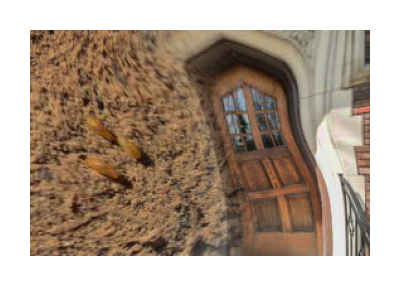

In [7]:
label = torch.tensor([[[77873,  6467]]]) #select two images

generator = torch.Generator('cuda')
generator.manual_seed(0xbee)

x = loader.batch_from_labels(label, torch_generator=generator) #merge and add distortion

fig = plt.figure(figsize=(1.5, 1), dpi=300)
imshow(fig.add_subplot(111), x[0])

## Equihash Function – Shannon-Hamming Loss

The model used in this demonstration is `ShannonHamming`, a ResNet-18 neural network trained on the OpenImages Mosaic train dataset using the Shannon-Hamming loss function. When applied to an instance, the model outputs 64 logits, each representing one of the 64 bits of the resulting fingerprint. For example, when applied to `x`, the output is:

In [8]:
fingerprint_logits = ShannonHamming(x)
print('Number if logits/bits:', fingerprint_logits.shape[1])
fingerprint_logits

Number if logits/bits: 64


tensor([[ 37.9042, -39.8291, -33.7151,  56.1405,  32.4716,  48.0576,  22.4857,
         -35.3103,  26.8462,  17.3286,  39.5404,  25.7205,  40.9932, -77.4921,
          27.9704,  53.6838,  48.0172,  56.7128, -19.3968,  -7.7255, -10.8695,
          45.1380,  24.3832, -48.6803,  38.0208,  -6.1462,  27.7486,  45.4686,
          22.2510, -21.6220,  35.0125,  22.1360,  50.0979,  40.8788,   3.5505,
         -21.0623, -23.9819,   3.2300,  -3.9554, -17.4800, -42.1963,  40.3239,
         -34.7278,  24.4434,   7.6878, -13.6249,  26.2698, -51.0524, -53.5602,
         -10.7629, -56.9092, -61.3979,  22.0935,  51.6123,  65.6271, -50.9064,
         -32.0881,  12.3046,  38.7739, -15.0905, -33.7767, -56.9692,  -4.2880,
         -63.1650]], device='cuda:0')

If a logit is negative, the probability that the corresponding bit is 1 is less than 0.5. Conversely, if the logit is positive, the probability that the bit is 1 exceeds 0.5. Therefore, the most probable fingerprint can be computed by applying the sign function to the logits.

In [9]:
fingerprint_bool = 0 < ShannonHamming(x)
fingerprint_bool

tensor([[ True, False, False,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True, False,  True,  True,  True,  True, False, False,
         False,  True,  True, False,  True, False,  True,  True,  True, False,
          True,  True,  True,  True,  True, False, False,  True, False, False,
         False,  True, False,  True,  True, False,  True, False, False, False,
         False, False,  True,  True,  True, False, False,  True,  True, False,
         False, False, False, False]], device='cuda:0')

From a memory perspective, encoding the fingerprint as 64 booleans is inefficient. Instead, we will use eight 8-bit unsigned integers, which is crucial when handling 1 billion fingerprints.

In [10]:
fingerprint_uint8 = Fingerprints(device='cuda').bool_to_uint8(fingerprint_bool).cpu().numpy()[0]
fingerprint_uint8

array([158, 251, 198, 187, 228,  90,  14,  96], dtype=uint8)

## Retrieval in a Database with 1 Billion Instances

The inverted index `ShannonHamming_ii` maps each fingerprint to a list of indices pointing to the instances in the database with that fingerprint. The index is built using a hash table and occupies 20GB of memory, with approximately 8GB used to store the 8-byte fingerprints of the 1 billion instances in the database.

In [11]:
print(ShannonHamming_ii.codes.shape)
ShannonHamming_ii.codes #fingerprints

(1000000000, 8)


array([[181, 103, 151, ..., 154, 177,  85],
       [  0,  30,  73, ...,  40, 159, 181],
       [ 48,  85, 230, ..., 160, 220,  27],
       ...,
       [196, 179, 198, ..., 179, 126,  22],
       [164, 148,  46, ...,  77,  28, 126],
       [194, 223, 250, ..., 150,  88,  63]], dtype=uint8)

The following code retrieves the index of each instance in the database that shares the same fingerprint as `x` in O(1) time.

In [12]:
retrieved_indexes = ShannonHamming_ii[fingerprint_uint8]
retrieved_indexes

[121168371, 339380002, 551318215]

By fetching and displaying the images corresponding to these indices, we can see that the system successfully retrieved three images from the same class as the query. In fact, these are the only instances in the database that belong to this class. This is what we refer to as a **perfect-retrieval**.

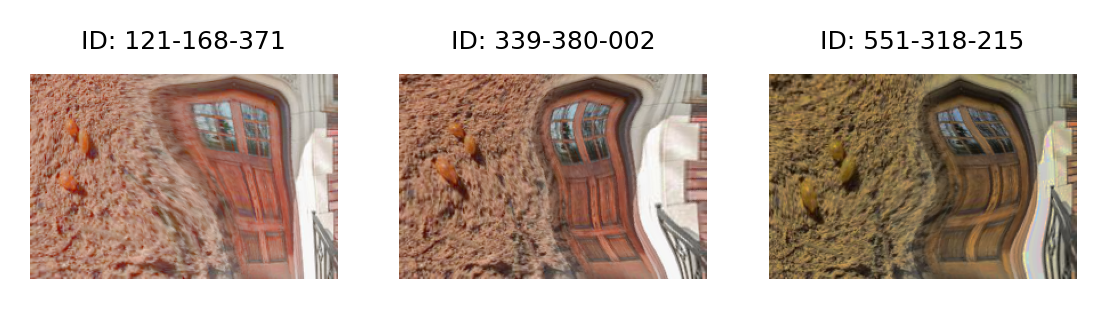

In [13]:
fig = plt.figure(figsize=(3*1.5, 1), dpi=300)
for n, i in enumerate(retrieved_indexes):
    imshow(fig.add_subplot(1, 3, n+1), database[i], title=f'ID: {idformat(i)}', size=6)

## Retrieval – Perfectness, Soundness & Completeness

In [14]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    
def timeformat(s):
    if int(s)>0: return f'{s:.2f} s'
    s *= 1000
    if int(s)>0: return f'{s:.2f} ms'
    s *= 1000
    if int(s)>0: return f'{s:.2f} µs'
    return f'{s/1000:.2f} ns'

def idformat(i):
    return '-'.join([str(i).zfill(9)[j*3:(j+1)*3] for j in range(3)])

def search(query_id, encoder, search_function, print_timing=False, ncols=5, nrows_limit=4):
    query = queries[query_id]
    torch.cuda.synchronize()
    
    t0 = time.time()
    with torch.no_grad():
        logits = encoder(query[None])[0]
        torch.cuda.synchronize()
    encoding_time = time.time() - t0
    
    t0 = time.time()
    index = search_function(logits)
    search_time = time.time() - t0
    
    
    gt = ground_truth[query_id]
    relevant = [i for i in index if i in gt]
    irrelevant = [i for i in index if i not in gt]
    
    if len(relevant) == len(gt) and len(irrelevant) == 0:
        print(bcolors.BOLD + bcolors.OKGREEN + "[PERFECT]" + bcolors.ENDC + ' retrieval:')
    else: print(bcolors.BOLD + bcolors.FAIL + "[INPERFECT]" + bcolors.ENDC + ' retrieval:')
    
    msg = f' {len(relevant)}/{len(gt)} relevant instance(s) found.'
    if len(relevant) == len(gt):
        print('    1) ' + bcolors.BOLD + bcolors.OKGREEN + "[COMPLETE]" + bcolors.ENDC + msg)
    elif len(relevant) > 0:
        print('    1) ' + bcolors.BOLD + bcolors.WARNING + "[INCOMPLETE]" + bcolors.ENDC + msg)
    else:
        print('    1) ' + bcolors.BOLD + bcolors.FAIL + "[INCOMPLETE]" + bcolors.ENDC + msg)
        
    msg = f' {len(irrelevant)} irrelevant instance(s) found.'
    if len(irrelevant) == 0:
        print('    2) ' + bcolors.BOLD + bcolors.OKGREEN + "[SOUND]" + bcolors.ENDC + msg)
    elif len(irrelevant) < 10:
        print('    2) ' + bcolors.BOLD + bcolors.WARNING + "[UNSOUND]" + bcolors.ENDC + msg)
    else:
        print('    2) ' + bcolors.BOLD + bcolors.FAIL + "[UNSOUND]" + bcolors.ENDC + msg)
        
    if print_timing:
        subtime = f'{timeformat(encoding_time)} (encoding) + {timeformat(search_time)} (search)'
        print(f'\n{len(index)} instance(s) retrieved in {timeformat(search_time + encoding_time)} [{subtime}]')
    
    display_retrieval(query_id, ground_truth_id=gt, retrieved_list=index, ncols=5, nrows_limit=4)
    
def display_retrieval(query_id, ground_truth_id, retrieved_list, ncols=5, nrows_limit=4):
    assert ncols >= 2 #otherwise no ground truth displayed
    assert ncols >= 1 #otherwise nothing displayed...

    irrelevant_retrieval = [i for i in retrieved_list if i not in ground_truth_id]
    retrieved_list = set(retrieved_list)

    nb_ir = len(irrelevant_retrieval)
    nrows = min(nrows_limit, 1 + nb_ir//ncols + bool(nb_ir%ncols))

    w_image, w_space, w_left_margin, w_right_margin = 270, 20, 20, 80
    width = ncols*w_image + (ncols-1)*w_space + w_left_margin + w_right_margin
    wr_image = w_image / width
    wr_space = w_space / width
    wr_left_margin = w_left_margin / width
    wr_right_margin = w_right_margin / width
    wspace = w_space / w_image #for gridspec

    h_header1, h_header2, h_image, h_space = 130, 160, 180, 40
    height = h_header1 + nrows*h_image + (h_header2 + (nrows-2)*h_space if nb_ir else 0)
    hr_header1 = h_header1 / height
    hr_header2 = h_header2 / height
    hr_image = h_image / height
    hr_space = h_space / height
    hspace = h_space / h_image #for gridspec

    width_inches = 16
    fig = plt.figure(figsize=(width_inches, width_inches*height/width), dpi=300)

    fig.text(0, 1, '.', size=1, color='white')
    fig.text(1, 1, '.', size=1, color='white')
    fig.text(0, 0, '.', size=1, color='white')
    fig.text(1, 0, '.', size=1, color='white')

    top = 1-hr_header1
    bottom = top - hr_image
    gs = fig.add_gridspec(nrows=1, ncols=1, top=top, bottom=bottom, left=wr_left_margin, right=wr_left_margin+wr_image)
    imshow(fig.add_subplot(gs[0]), queries[query_id], 'Query', size=20)

    nb_gt_displayed = min(ncols-1, len(ground_truth_id))
    nb_gt_not_displayed = len(ground_truth_id) - nb_gt_displayed
    left = wr_left_margin + wr_image + wr_space
    right = left + nb_gt_displayed*wr_image + (nb_gt_displayed-1)*wr_space

    gs = fig.add_gridspec(nrows=1, ncols=nb_gt_displayed, top=top, bottom=bottom, left=left, right=right, wspace=wspace)
    for n in range(nb_gt_displayed):
        i = ground_truth_id[n]
        if i in retrieved_list:
            found = 'FOUND'
            color = 'green'
        else:
            found = 'NOT FOUND'
            color = 'red'
        imshow(fig.add_subplot(gs[n]), database[i], f'[{found}]\nID: {idformat(i)}', color=color, size=14)

    if nb_gt_not_displayed:
        fig.text(1, top, f'[+{nb_gt_not_displayed}]', horizontalalignment='right', verticalalignment='top', size=12)
        right += wr_right_margin #this affects the annotate bellow

    ax = fig.add_subplot(fig.add_gridspec(nrows=1, ncols=1, top=1, bottom=1-hr_header1, left=0, right=1)[0])
    ax.set_axis_off()
    ax.annotate('Relevant Instances\n(Ground Truth)', xy=((left+right)/2, 0.4), xytext=((left+right)/2, 1), xycoords='axes fraction', 
                fontsize=16, ha='center', va='top',
                bbox=dict(boxstyle='square', fc='white', color='k'),
                arrowprops=dict(arrowstyle=f'-[, widthB={2.25*(right-left+wr_space)*width_inches}, lengthB=0.25', lw=1.0, color='k'))    

    if nrows >= 2:
        nb_ir_displayed = min((nrows-1)*ncols, len(irrelevant_retrieval))
        nb_ir_not_displayed = len(irrelevant_retrieval) - nb_ir_displayed
        nb_ir_cols = min(ncols, nb_ir_displayed)
        top = bottom - hr_header2
        left = wr_left_margin
        right = wr_left_margin + nb_ir_cols*wr_image + (nb_ir_cols-1)*wr_space

        gs = fig.add_gridspec(nrows=nrows-1, ncols=nb_ir_cols, top=top, bottom=0, left=left, right=right, wspace=wspace, hspace=hspace)
        for n in range(nb_ir_displayed):
            i = irrelevant_retrieval[n]
            imshow(fig.add_subplot(gs[n]), database[i], f'ID: {idformat(i)}', color='red', size=14)

        if nb_ir_not_displayed:
            fig.text(1, bottom-hr_header2, f'[+{nb_ir_not_displayed}]', horizontalalignment='right', verticalalignment='top', size=12)
            right += wr_right_margin #this affects the annotate bellow

        ax = fig.add_subplot(fig.add_gridspec(nrows=1, ncols=1, top=bottom, bottom=bottom-hr_header2, left=0, right=1)[0])
        ax.set_axis_off()
        ax.annotate('Irrelevant Instances\nRetrieved', xy=((left+right)/2, 0.25), xytext=((left+right)/2, 0.75), xycoords='axes fraction', 
                    fontsize=16, ha='center', va='top',
                    bbox=dict(boxstyle='square', fc='white', color='k'),
                    arrowprops=dict(arrowstyle=f'-[, widthB={2.25*(right-left+wr_space)*width_inches}, lengthB=0.25', lw=1.0, color='k'))

[PERFECT] retrieval:
    1) [COMPLETE] 3/3 relevant instance(s) found.
    2) [SOUND] 0 irrelevant instance(s) found.

3 instance(s) retrieved in 4.07 ms [3.82 ms (encoding) + 246.76 µs (search)]


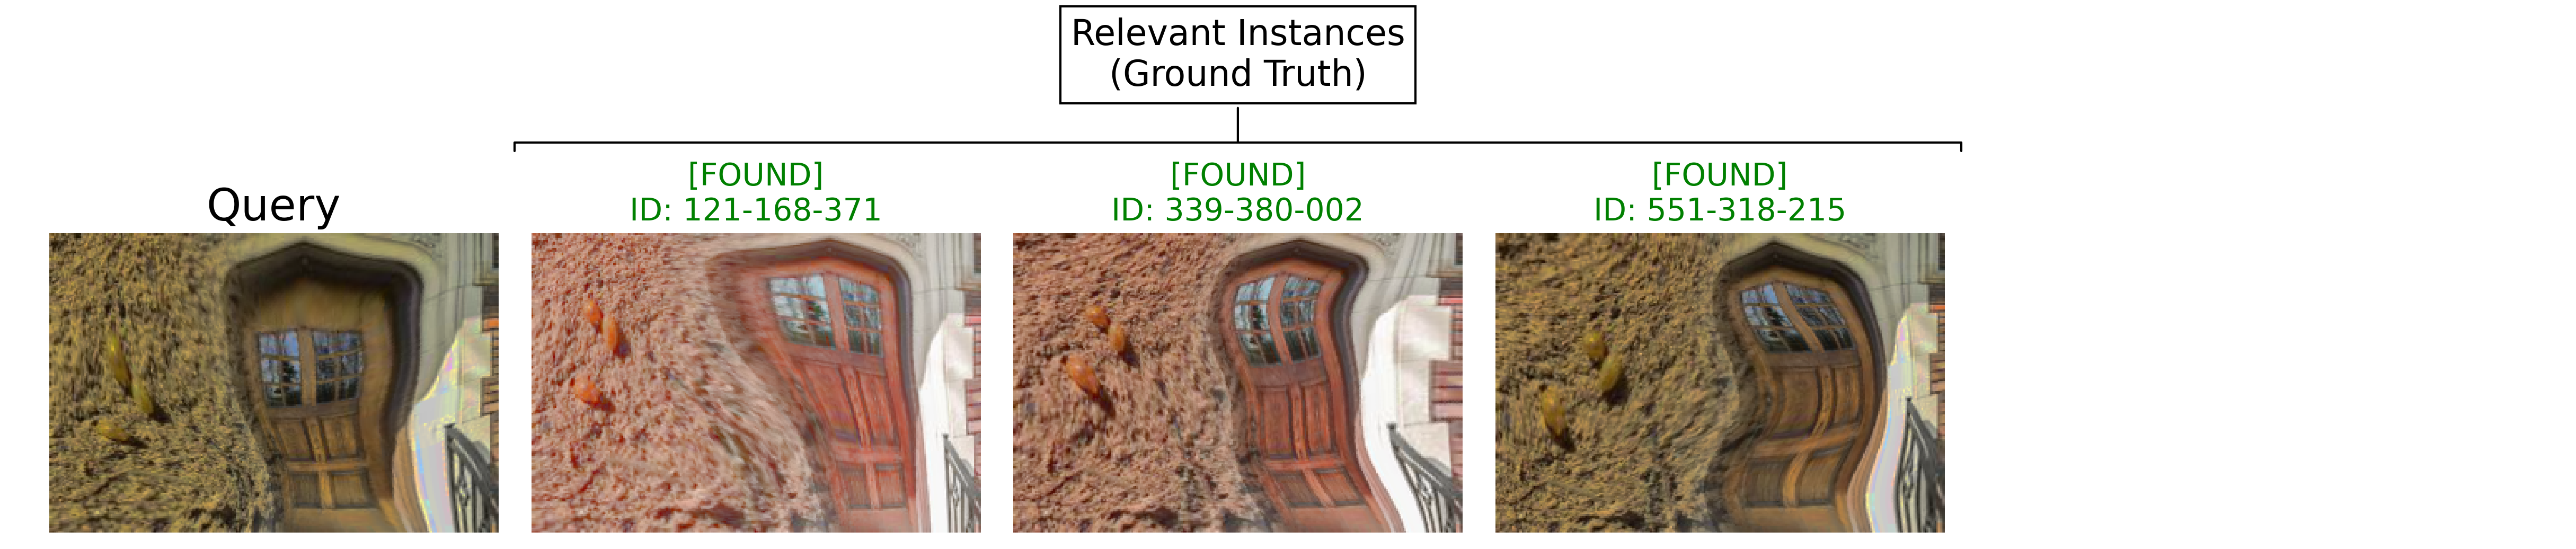

In [15]:
#queries with perfect-retrieval: 148362, 4483, 167170, 220038
#queries with incomplete but sound retrieval: 34, 61, 207, 230, 733
#queries with complete but unsound retrieval: 1112, 4215, 7534, 11005, 11071

search(
    query_id=148362,
    encoder=ShannonHamming,
    search_function=PrioritizedMultiProbing(ShannonHamming_ii, number_lookups=1),
    print_timing=True,
)

## Prioritized Multi-Probing

To enhance the complete-retrieval rate, we can explore neighboring fingerprints. Recall that the neural network outputs the logits for each bit.

In [16]:
fingerprint_logits

tensor([[ 37.9042, -39.8291, -33.7151,  56.1405,  32.4716,  48.0576,  22.4857,
         -35.3103,  26.8462,  17.3286,  39.5404,  25.7205,  40.9932, -77.4921,
          27.9704,  53.6838,  48.0172,  56.7128, -19.3968,  -7.7255, -10.8695,
          45.1380,  24.3832, -48.6803,  38.0208,  -6.1462,  27.7486,  45.4686,
          22.2510, -21.6220,  35.0125,  22.1360,  50.0979,  40.8788,   3.5505,
         -21.0623, -23.9819,   3.2300,  -3.9554, -17.4800, -42.1963,  40.3239,
         -34.7278,  24.4434,   7.6878, -13.6249,  26.2698, -51.0524, -53.5602,
         -10.7629, -56.9092, -61.3979,  22.0935,  51.6123,  65.6271, -50.9064,
         -32.0881,  12.3046,  38.7739, -15.0905, -33.7767, -56.9692,  -4.2880,
         -63.1650]], device='cuda:0')

A value close to zero indicates that the neural network is uncertain about a specific bit. The prioritized multi-probing algorithm performs `number_lookups` lookups using the most probable fingerprints, allowing us to mitigate model uncertainty while maintaining O(1) time complexity.

[PERFECT] retrieval:
    1) [COMPLETE] 1/1 relevant instance(s) found.
    2) [SOUND] 0 irrelevant instance(s) found.

1 instance(s) retrieved in 31.80 ms [3.53 ms (encoding) + 28.27 ms (search)]


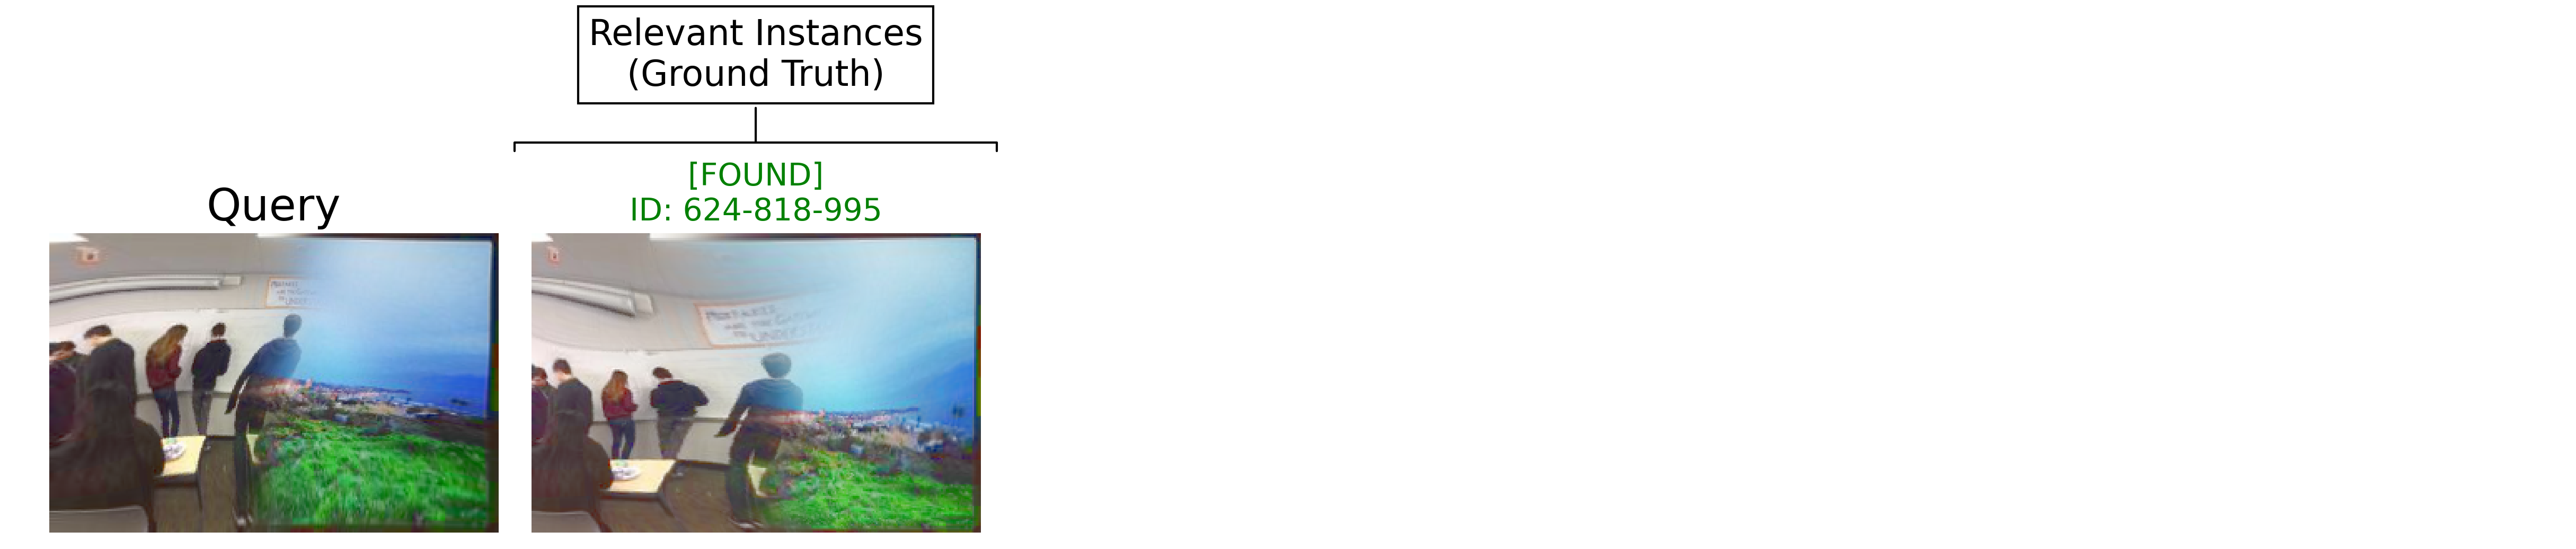

In [17]:
#query_id 9 --> 2 lookups
#query_id 18 --> 3 lookups
#query_id 24 --> 2 lookups
#query_id 12 --> 257 lookups
#query_id 27 --> 1240 lookups

search(
    query_id=27,
    encoder=ShannonHamming,
    search_function=PrioritizedMultiProbing(ShannonHamming_ii, number_lookups=1240),
    print_timing=True,
)